# Building a Model to Build a Better Team
#### Can we use a team's performance the previous year to predict who they will take in the first round of the upcoming NFL draft?

In [3]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import cross_validation
from sklearn import svm
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from pandas import DataFrame

I've compiled a .csv file, draft_rankings.csv, that spans 10 NFL seasons (still adding to the list), detailing the offensive and defensive ranking, sorted by yards gained and allowed, respectively. The final column denotes which side of the ball that their first draft pick played. For teams with multiple first round draft picks, I've only included their first pick.

I took this coarse statistical view to avoid contamination from similar statistics (e.g. total yards, passing yards, rushing yards). This seems like the most reasonable first pass approach.

In [4]:
pd.read_csv("~/Desktop/draft_rankings.csv").head()

,Team,Year,Orank,Drank,IsOffense,Pick
0,Arizona Cardinals,2006,18,29,1.0,5.0
1,Atlanta Falcons,2006,12,22,0.0,8.0
2,Baltimore Ravens,2006,17,1,1.0,29.0
3,Buffalo Bills,2006,30,18,1.0,12.0
4,Carolina Panthers,2006,24,7,0.0,25.0


Load in the relevant data and omit teams with no first round draft pick from the model:

In [5]:
all_teams=pd.read_csv("draft_rankings.csv")
picks=all_teams.dropna(subset=['IsOffense'])
print picks.head()

                Team  Year  Orank  Drank  IsOffense  Pick
0  Arizona Cardinals  2006     18     29        1.0   5.0
1    Atlanta Falcons  2006     12     22        0.0   8.0
2   Baltimore Ravens  2006     17      1        1.0  29.0
3      Buffalo Bills  2006     30     18        1.0  12.0
4  Carolina Panthers  2006     24      7        0.0  25.0


In [6]:
df = pd.DataFrame(picks, columns=['Orank', 'Drank', 'IsOffense'])
data_array = df.as_matrix()

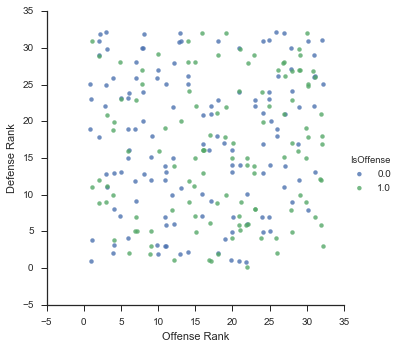

In [7]:
sns.set_context("notebook", font_scale=1.1)
sns.set(style="ticks")
sns.lmplot('Orank', 'Drank', data=df, hue='IsOffense', fit_reg=False, x_jitter=.15, y_jitter=.15)
plt.xlabel("Offense Rank")
plt.ylabel("Defense Rank")
plt.show()

2D scatter plot doesn't show strong clusters of tendencies. Bad defensive teams still pick offensive guys, and vice versa. Most interesting regions are top left and bottom right (the poles). Intriguingly, why do teams with great defenses not seem to have terrible offenses? This is yards allowed, after all...

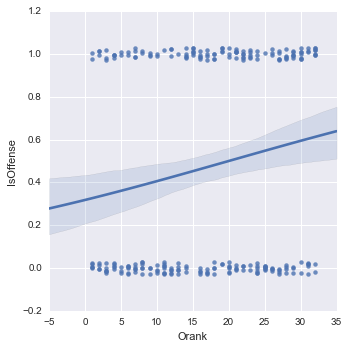

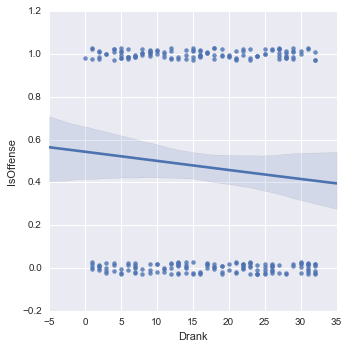

In [8]:
sns.set_context("notebook", font_scale=1.1)
sns.set(style="darkgrid")
sns.lmplot(x='Orank', y='IsOffense', data=df, logistic=True, y_jitter=.03);
sns.lmplot(x='Drank', y='IsOffense', data=df, logistic=True, y_jitter=.03);
plt.show()

Maybe a logistic regression could show some tendencies. Orrrrr not. Time to split the data into training and test sets to see if machine learning can uncover anything invisible to the eye.

In [9]:
stats = data_array[:, 1:3]
draftpick = data_array[:,2]
rankings=pd.DataFrame(picks, columns=['Orank', 'Drank'])

X_train, X_test, y_train, y_test = cross_validation.train_test_split(rankings, draftpick, test_size=0.25, random_state=3)

X_train.shape, y_train.shape


((190, 2), (190,))

I like the thought of a KNN approach here. Though a pattern doesn't seem too apparent from the 2D scatter plot above, local clustering could be predictive. Or, general probability (3/5 might not be very obvious visually, but could be useful for modeling)...

## K-Nearest Neighbors

In [10]:
k_range=range(1,31)
k_scores=[]
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores=cross_val_score(knn, rankings, draftpick, cv=10, scoring='accuracy')
    k_scores.append(scores.mean())
print k_scores
avg_kscore = sum(k_scores)/len(k_scores)


[0.51076923076923075, 0.49169230769230765, 0.54599999999999993, 0.54661538461538461, 0.55846153846153845, 0.55830769230769239, 0.51476923076923087, 0.51523076923076927, 0.50353846153846149, 0.52707692307692311, 0.49215384615384616, 0.49184615384615382, 0.51523076923076938, 0.52723076923076928, 0.53538461538461546, 0.54338461538461524, 0.52369230769230768, 0.52769230769230757, 0.53153846153846152, 0.55907692307692314, 0.52353846153846151, 0.52753846153846162, 0.51569230769230767, 0.53107692307692311, 0.52353846153846162, 0.49984615384615383, 0.51200000000000001, 0.50461538461538469, 0.52415384615384619, 0.51200000000000001]


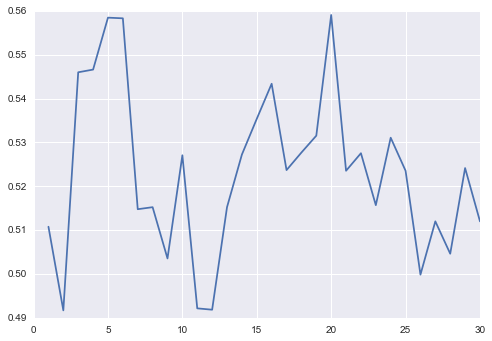

In [11]:
plt.plot(k_range, k_scores)

In [12]:
knn20_model=KNeighborsClassifier(n_neighbors=20)
knn20_model.fit(X_train, y_train)
print knn20_model.predict([[12,20]])

[ 0.]


Well that's not very good. After playing with the number of nearest neighbors, it's pretty apparent that this isn't a much more useful approach than flipping a coin. Are there any other models that perform better?

## Logistic Regression

In [13]:
logreg = LogisticRegression()
scores=cross_val_score(logreg, rankings, draftpick, cv=10, scoring='accuracy')
print scores
print scores.mean()

[ 0.61538462  0.5         0.57692308  0.57692308  0.52        0.52        0.68
  0.36        0.68        0.48      ]
0.550923076923


In [14]:
logreg_model = logreg.fit(X_train, y_train)
print logreg_model.score(X_train, y_train)
print logreg_model.predict([[12,20]])

0.563157894737
[ 0.]


Overall, it looks like logistic regression is SLIGHTLY better than KNN. Nevertheless, about the best I can get is 60% accuracy. Logistic regression accuracy is improved when both offense and defense performance are included, which intuitively makes sense. But still, this is pretty weak.

## Random Forest

In [15]:
rf_model = RandomForestClassifier()
scores=cross_val_score(rf_model, rankings, draftpick, cv=10, scoring='accuracy')
rf_model = rf_model.fit(X_train, y_train)
print scores
print scores.mean()

[ 0.65384615  0.57692308  0.5         0.61538462  0.48        0.56        0.4
  0.4         0.4         0.44      ]
0.502615384615


In [16]:
rf_model.predict([[12,20]])

array([ 0.])

## Support Vector Machine

In [17]:
svm_model=svm.SVC()
scores=cross_val_score(svm_model, rankings, draftpick, cv=10, scoring='accuracy')
print scores
print scores.mean()

[ 0.69230769  0.57692308  0.57692308  0.65384615  0.56        0.6         0.36
  0.56        0.52        0.44      ]
0.554


In [18]:
svm_model = svm_model.fit(X_train, y_train)
svm_model.predict([[12,20]])

array([ 1.])

Overall, I'm not really seeing any significant improvement over a coin flip. Logistic regression seems to be the most accurate, but it's only about 55% accurate. I'll need to search elsewhere for features if I want to predict the draft.

One final question with this data: which teams focus more on balancing their team with their first round draft pick, and which teams tend to stockpile their talent on one side of the ball?

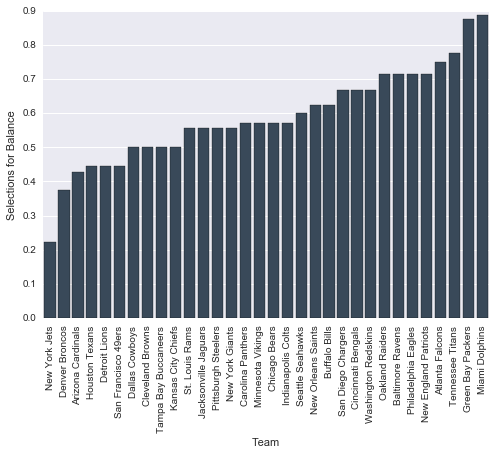

In [19]:
offensive_hist = {}
total_picks_hist = {}
for team in picks['Team'].unique():
    offensive_hist.update({team : 0})
    total_picks_hist.update({team : 0})
    

filename = open("/Users/gstarek/Desktop/draft_rankings.csv", 'r')    
    
for team in picks['Team'].unique():
    for line in filename.readlines(): 
        if line.split(",")[0] == team:
            if line.split(",")[4] != "":
                total_picks_hist[team] += 1
                if int(line.split(",")[2]) > int(line.split(",")[3]):
                    if line.split(",")[4] == "1":
                        offensive_hist[team] += 1
                if int(line.split(",")[2]) < int(line.split(",")[3]):
                    if line.split(",")[4] == "0":
                        offensive_hist[team] += 1
                if int(line.split(",")[2]) == int(line.split(",")[3]):
                    offensive_hist[team] += 1
    filename.seek(0)


smart_moves={}
for team in picks['Team'].unique():
    smart_moves.update({team : float(offensive_hist.get(team))/float(total_picks_hist.get(team))})


s=pd.DataFrame(list(smart_moves.iteritems()),
                      columns=['Team','Rank Attention'])

rankings=s.sort_values(by=['Rank Attention'], ascending=[1])

rank_plot=sns.barplot(x='Team', y='Rank Attention', data=rankings, color="#34495e")
rank_plot.set_ylabel("Selections for Balance")

for item in rank_plot.get_xticklabels():
    item.set_rotation(90)



#### To Do:
1. ~~Augment dataset to increase sampling. Could reduce stochasticity in data.~~
  * Added two more years to round out dataset to 10 years, and performance didn't really improve
2. Slice statistics to a more granular level (passing yards, rushing yards, tackles, turnovers). Skeptical about the ROI here, though.
3. Look at "expert predictions". There's a lot that this method ignores: free agency, retirement, devastating injuries, etc., that could influence the way a team will pick. 
4. Add which draft pick the team had to the data set. Does the model hold up better for the first few picks, and then fall apart when teams start taking the best remaining player, regardless of need?